In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from dictys.net import dynamic_network

In [2]:
from utils_custom import *

## Execute the analysis

In [3]:
# Define file paths 
data_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output/dynamic.h5'
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output'
tf_pairs_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/combinatorial_control/SLIDE_LF_enriched_pair_GC-1_PB-2.csv'

In [4]:
# Load data
dictys_dynamic_object = load_data(data_file)

In [7]:
# Define the transcription factors
tf_list = ['BACH2', 'BATF', 'IRF4', 'PRDM1']
# Get the TF indices
tf_indices, gene_indices = get_tf_indices(dictys_dynamic_object, tf_list)
print(f"TF indices: {tf_indices}")
print(f"Gene indices: {gene_indices}")

TF indices: [9, 10, 97, 172]
Gene indices: [978, 997, 5093, 8469]


In [8]:
# Assign window indices for each branch between 0 to 60
pb_window_indices = list(range(30, 46)) + [2]
#abc_window_indices = [1] + list(range(4, 30)) + [0]
gc_window_indices = list(range(46, 61)) + [3]

### Regulation strength across each branch

In [13]:
# Debug information before getting weights
print("==== Debug Information ====")
print("Array shape:", dictys_dynamic_object.prop['es']['w_n'].shape)
print("TF indices:", tf_indices)
print("PB window indices:", pb_window_indices)
print("GC window indices:", gc_window_indices)
print("========================")

# get normalized weights
weights_of_tf_target_pb = get_weights_across_windows(dictys_dynamic_object, tf_indices, pb_window_indices)
#weights_of_tf_target_abc = get_weights_across_windows(dictys_dynamic_object, tf_indices, abc_window_indices)
weights_of_tf_target_gc = get_weights_across_windows(dictys_dynamic_object, tf_indices, gc_window_indices)

==== Debug Information ====
Array shape: (245, 13169, 61)
TF indices: [9, 10, 97, 172]
PB window indices: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 2]
GC window indices: [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 3]


In [14]:
# get normalized weights
print(weights_of_tf_target_pb.shape)
#print(weights_of_tf_target_abc.shape)
print(weights_of_tf_target_gc.shape)


(4, 13169, 17)
(4, 13169, 16)


In [10]:
### Plotting node degree

# get non-zero weights per tf (node-degree)
non_zero_weights_per_tf_pb = np.count_nonzero(weights_of_tf_target_pb, axis=1)
#non_zero_weights_per_tf_abc = np.count_nonzero(weights_of_tf_target_abc, axis=1)
non_zero_weights_per_tf_gc = np.count_nonzero(weights_of_tf_target_gc, axis=1)


In [15]:
# subset the weight matrix to only include the gene_indices from our TF list
weights_of_tf_target_pb_subset = weights_of_tf_target_pb[:, gene_indices, :]
#weights_of_tf_target_abc_subset = weights_of_tf_target_abc[:, gene_indices, :]
weights_of_tf_target_gc_subset = weights_of_tf_target_gc[:, gene_indices, :]

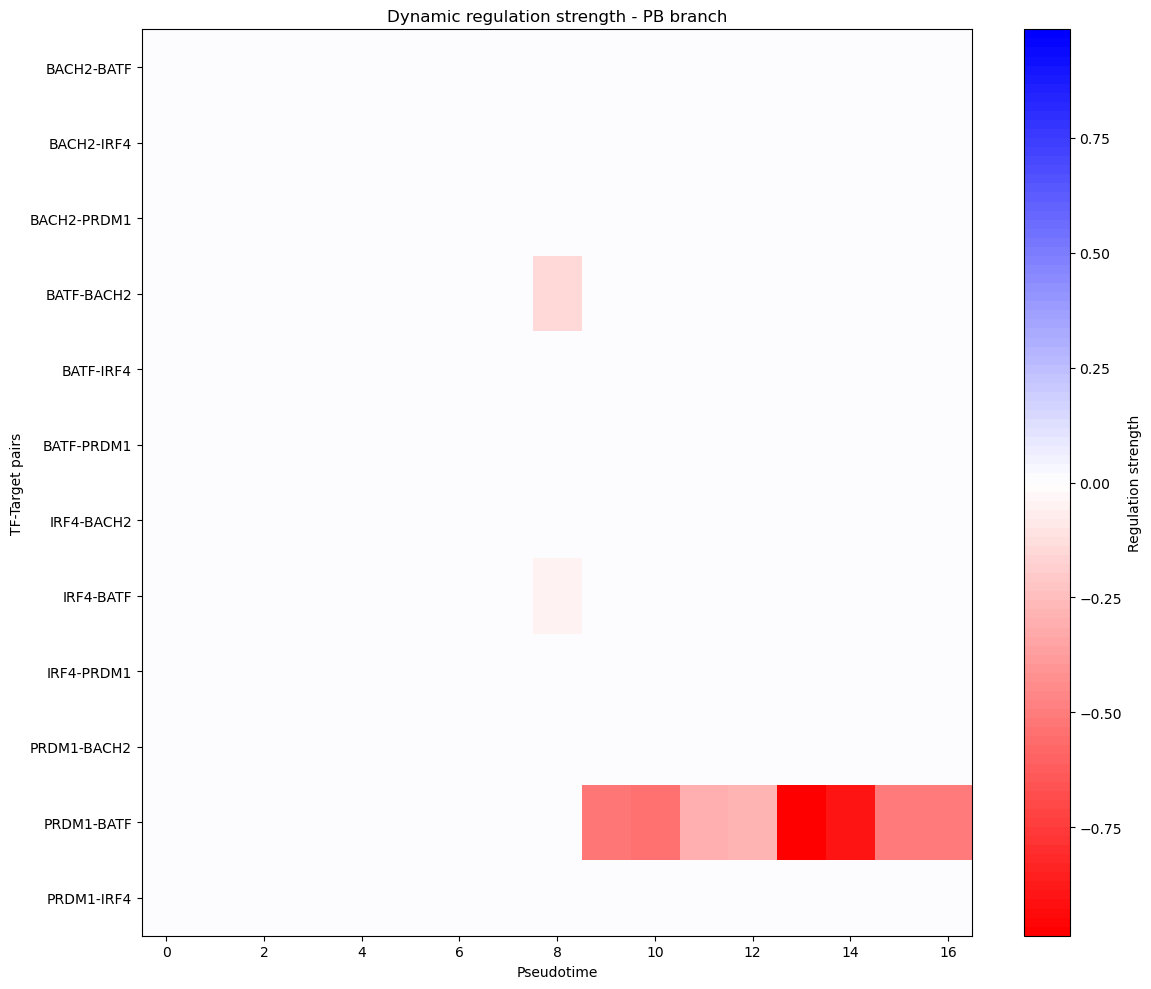

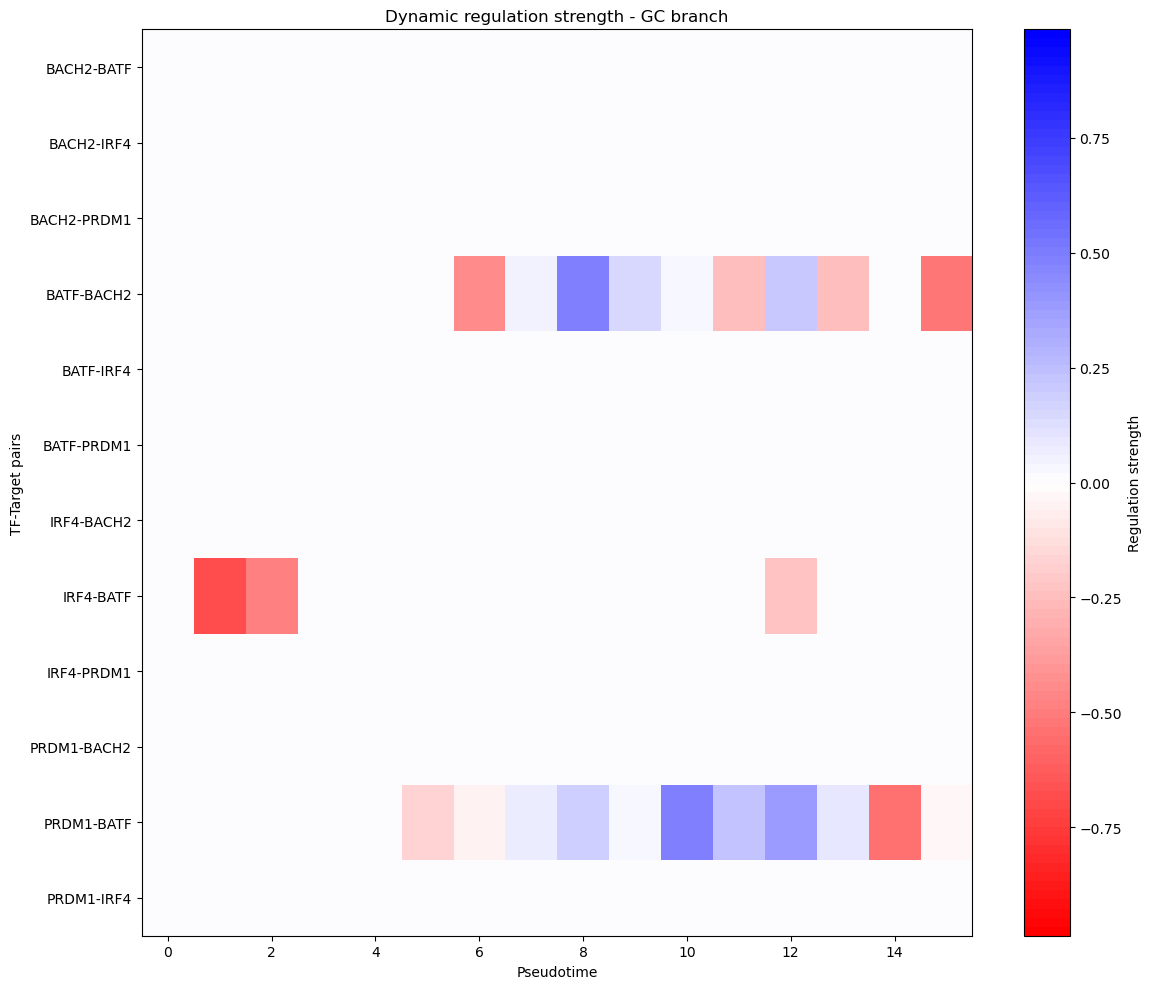

In [16]:
# Calculate global min and max across all branches
all_weights = np.concatenate([
    weights_of_tf_target_pb_subset.flatten(),
    weights_of_tf_target_gc_subset.flatten()
])
global_vmin = np.min(all_weights)
global_vmax = np.max(all_weights)
global_vmax = max(abs(global_vmin), abs(global_vmax))
global_vmin = -global_vmax

# plot heatmap of weights per branch
plot_regulation_heatmap(weights_of_tf_target_pb_subset, tf_list, 'PB', global_vmin, global_vmax)
plot_regulation_heatmap(weights_of_tf_target_gc_subset, tf_list, 'GC', global_vmin, global_vmax)


### Expression of TFs across branches

In [ ]:
# plot log CPM of TFs across branches
plot_log_cpm_tfs(dictys_dynamic_object, gene_indices, pb_window_indices, tf_list, 'PB')
plot_log_cpm_tfs(dictys_dynamic_object, gene_indices, gc_window_indices, tf_list, 'GC')


In [ ]:
# plot gradients of TF expression across branches
gradients_pb = calculate_and_plot_expression_gradients(
    dictys_dynamic_object, 
    gene_indices, 
    pb_window_indices, 
    tf_list, 
    'PB'
)

gradients_gc = calculate_and_plot_expression_gradients(
    dictys_dynamic_object, 
    gene_indices, 
    gc_window_indices, 
    tf_list, 
    'GC'
)



## SLIDE enrichment analysis

#### expression

In [5]:
def plot_tf_pairs_gradients(branch_name, tf_pairs=None, n_top_pairs=3):
    """
    Plot expression gradients for TF pairs for a specific branch using the existing function.
    """
    # Get appropriate window indices based on branch name
    if branch_name == 'PB':
        window_indices = pb_window_indices
    elif branch_name == 'GC':
        window_indices = gc_window_indices
    else:
        raise ValueError("branch_name must be either 'PB' or 'GC'")
    
    # Get TF pairs either from input or CSV
    if tf_pairs is None:
        # Read and sort the TF pairs from CSV
        df = pd.read_csv(tf_pairs_file)
        top_pairs = df.nlargest(n_top_pairs, 'Score')
        tf_pairs = [eval(pair) for pair in top_pairs['TF']]
    
    # Get unique TFs from pairs
    unique_tfs = list(set([tf for pair in tf_pairs for tf in pair]))

    # Get TF indices
    tf_indices, gene_indices = get_tf_indices(dictys_dynamic_object, unique_tfs)
    
    # Use the existing function to plot
    calculate_and_plot_expression_gradients(
        dictys_dynamic_object, 
        gene_indices, 
        window_indices,
        unique_tfs, 
        branch_name
    )


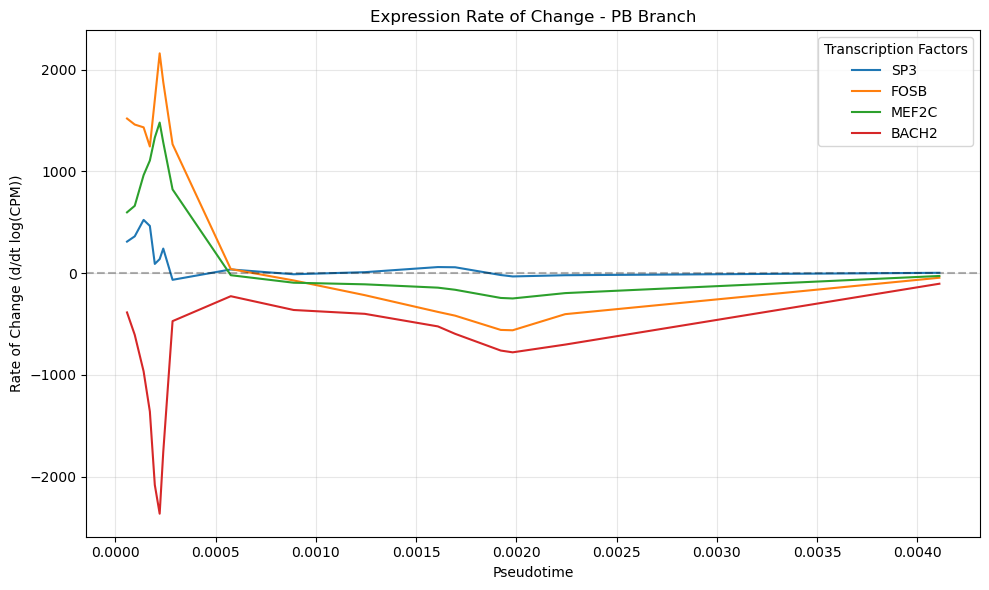

In [10]:
# plot top 3 pairs from CSV
plot_tf_pairs_gradients('PB')


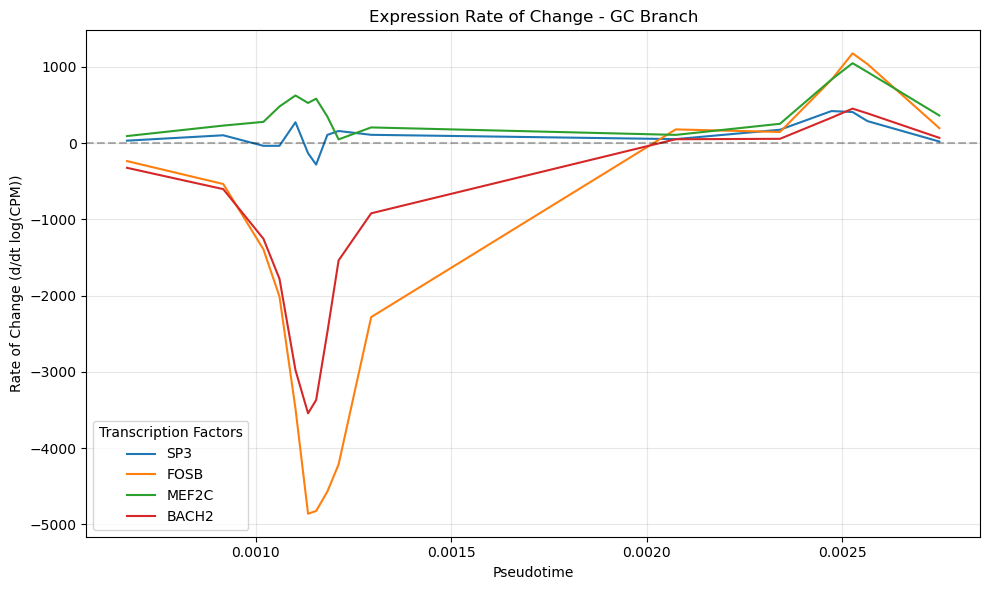

In [11]:
plot_tf_pairs_gradients('GC')

#### regulation

In [ ]:
def extract_tf_pair_regulation(dictys_dynamic_object, tf_pairs_file, window_indices, branch_name, output_dir):
    """
    Extract TF-Target regulation patterns across pseudotime and save to files for later analysis.
    
    Parameters:
    -----------
    dictys_dynamic_object : dictys object
        The dynamic network object containing weights data
    tf_pairs_file : str
        Path to CSV file containing TF pairs and their common targets
    window_indices : list
        Indices of windows to analyze
    branch_name : str
        Name of the branch for plotting
    output_dir : str
        Directory to save temporary files
    """
    # Read TF pairs and their targets
    tf_pairs_df = pd.read_csv(tf_pairs_file)
    
    # Initialize lists to store data
    all_weights = []
    pair_labels = []
    
    # Get gene mapping
    gene_hashmap = dictys_dynamic_object.ndict
    
    for _, row in tf_pairs_df.iterrows():
        # Parse TF pair and targets
        tf1, tf2 = eval(row['TF'])
        common_targets = eval(row['common'])
        
        # Get TF indices for both TFs
        tf1_indices, _ = get_tf_indices(dictys_dynamic_object, [tf1])
        tf2_indices, _ = get_tf_indices(dictys_dynamic_object, [tf2])
        
        # Get indices for common target genes
        target_gene_indices = []
        for target in common_targets:
            if target in gene_hashmap:
                target_gene_indices.append(gene_hashmap[target])
        
        if not (tf1_indices and tf2_indices and target_gene_indices):
            continue
            
        # Get weights for both TFs across windows
        weights_tf1 = get_weights_across_windows(dictys_dynamic_object, tf1_indices, window_indices)
        weights_tf2 = get_weights_across_windows(dictys_dynamic_object, tf2_indices, window_indices)
        
        # Extract weights only for common target genes
        weights_tf1_subset = weights_tf1[:, target_gene_indices, :]
        weights_tf2_subset = weights_tf2[:, target_gene_indices, :]
        
        # Combine weights for each target
        for i, target_idx in enumerate(target_gene_indices):
            target_name = list(common_targets)[i]
            pair_labels.append(f"{tf1} → {target_name}")
            pair_labels.append(f"{tf2} → {target_name}")

            w1 = weights_tf1_subset[0, i, :]
            w2 = weights_tf2_subset[0, i, :]
            combined_weights = np.vstack([w1, w2])
            all_weights.append(combined_weights)
    
    # Convert to numpy array
    all_weights = np.array(all_weights)
    
    # Save data to files
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, f'weights_{branch_name}.npy'), all_weights)
    
    # Save labels as text file
    with open(os.path.join(output_dir, f'labels_{branch_name}.txt'), 'w') as f:
        for label in pair_labels:
            f.write(f"{label}\n")
    
    print(f"Saved data for {branch_name} branch:")
    print(f"Weights shape: {all_weights.shape}")
    print(f"Number of TF-target pairs: {len(pair_labels)}")
    
    return {
        'weights_file': os.path.join(output_dir, f'weights_{branch_name}.npy'),
        'labels_file': os.path.join(output_dir, f'labels_{branch_name}.txt')
    }

def cluster_and_plot_regulation(weights_file, labels_file, branch_name, global_vmin=None, global_vmax=None):
    """
    Load saved weights and labels, perform clustering, and create heatmap visualization.
    
    Parameters:
    -----------
    weights_file : str
        Path to the .npy file containing weights
    labels_file : str
        Path to the text file containing labels
    branch_name : str
        Name of the branch for plotting
    global_vmin : float, optional
        Global minimum for color scaling
    global_vmax : float, optional
        Global maximum for color scaling
    """
    # Load data
    all_weights = np.load(weights_file)
    with open(labels_file, 'r') as f:
        pair_labels = [line.strip() for line in f]
    
    # Treat each TF-target relationship independently for clustering
    X_for_clustering = all_weights.reshape(len(all_weights), -1)
    
    # Perform hierarchical clustering
    from scipy.cluster.hierarchy import dendrogram, linkage
    linkage_matrix = linkage(X_for_clustering, method='ward')
    cluster_order = dendrogram(linkage_matrix, no_plot=True)['leaves']
    
    # Reorder weights and labels based on clustering
    all_weights = all_weights[cluster_order]
    pair_labels = [pair_labels[i] for i in cluster_order]
    
    # Plot heatmap
    plt.figure(figsize=(12, len(pair_labels) * 0.3))
    weights_reshaped = all_weights.reshape(len(pair_labels), -1)
    
    if global_vmin is None or global_vmax is None:
        abs_max = np.max(abs(weights_reshaped))
        global_vmin = -abs_max
        global_vmax = abs_max
    
    colors_list = ['red', 'white', 'blue']
    n_bins = 100
    cmap = colors.LinearSegmentedColormap.from_list('custom', colors_list, N=n_bins)
    
    im = plt.imshow(weights_reshaped, 
                    aspect='auto', 
                    cmap=cmap, 
                    interpolation='nearest',
                    vmin=global_vmin,
                    vmax=global_vmax)
    
    plt.colorbar(im, label='Regulation strength')
    plt.xlabel('Pseudotime')
    plt.ylabel('TF-Target pairs')
    plt.title(f'Dynamic regulation strength - {branch_name} branch')
    plt.yticks(range(len(pair_labels)), pair_labels)
    plt.tight_layout()
    plt.show()
    
    return {
        'weights': all_weights,
        'labels': pair_labels,
        'cluster_order': cluster_order
    }

In [ ]:
# Extract data for both branches
gc_files = extract_tf_pair_regulation(
    dictys_dynamic_object,
    tf_pairs_file,
    gc_window_indices,
    'GC',
    output_folder
)

pb_files = extract_tf_pair_regulation(
    dictys_dynamic_object,
    tf_pairs_file,
    pb_window_indices,
    'PB',
    output_folder
)

# Calculate global min/max for consistent color scaling
gc_weights = np.load(gc_files['weights_file'])
pb_weights = np.load(pb_files['weights_file'])
all_weights = np.concatenate([gc_weights.flatten(), pb_weights.flatten()])
global_vmax = max(abs(np.min(all_weights)), abs(np.max(all_weights)))
global_vmin = -global_vmax

In [ ]:
# Plot with consistent color scaling
gc_results = cluster_and_plot_regulation(
    weights_file=gc_files['weights_file'],
    labels_file=gc_files['labels_file'],
    branch_name='GC',
    global_vmin=global_vmin,
    global_vmax=global_vmax
)

pb_results = cluster_and_plot_regulation(
    weights_file=pb_files['weights_file'],
    labels_file=pb_files['labels_file'],
    branch_name='PB',
    global_vmin=global_vmin,
    global_vmax=global_vmax
)